# Final Model

This model results from editing code generated by PerplexityAI (GPT-3.5)$^1$. For details about how the code was adapted from the output of a LLM, see the code provided in indiv_iters marked by _MODIFICATIONS.

The model can be run using the code provided below. The general parameters have been set up outside the model code and can be changed if desired. A trace function has been provided to change whether model information (patient arrivals and discharges) should be printed out while the code is being run. 

The length of stay, inter-arrival times and probability of patients exiting to one of the three locations (ESD, rehab or other) are sampled from distributions classes. The Scenario class holds model variables and samples from these distributions. 

The StrokeWard class contains the processes which a patient goes through. The patients are being generated, admitted to the ward when there is a bed, stay for a length of time and then discharged to one of the three locations. The Patient class is used to hold information about that patient.

A single run of the model can be performed using the single_run function. Multiple replications can be performed using the multiple_runs function. The resulting summary data frame can be used to plot histograms of the performance metrics. 

A warm-up analysis can be performed to check the length of the warm-up period needed for the model run using warmup_analysis and time_series_inspection functions. The warm-up period and results collection period can be set before running the model in either single_run or multiple_runs. The number of beds in the ward can also be changed. 

#### Acknowledgements

We acknowledge the use of PerplexityAI to generate python code that we have adapted to create the simulation model presented here. The AI-generated code can be found in the cont_iters and indiv_iters folders. We confirm that no content generated by AI has been presented as our own work.

#### References

1. PerplexityAI (2022). PerplexityAI in response to <>, March 2024.

#### Imports

In [1]:
import simpy
import numpy as np
import math
import pandas as pd
import itertools
import random
import matplotlib.pyplot as plt

#### Parameters

In [2]:
# Beds in stroke ward
NUM_BEDS = 10
# Patient types that can arrive
PATIENTS = ['Stroke', 'TIA', 'Complex NL', 'Other']

# Interarrival times for patients
STROKE_IAT = 1.2
TIA_IAT = 9.3
CNL_IAT = 3.6
OTHER_IAT = 3.2

# Mortality of patient probability
STROKE_MORT_PROB = 0.02

# Length of stay parameters for patients (mean and stdev)
STROKE_LOS = (7.4, 8.6)
STROKE_ESD_LOS = (4.6, 4.8)
STROKE_MORT_LOS = (7.0, 8.7)
TIA_LOS = (1.8, 2.3)
CNL_LOS = (4.0, 5.0)
OTHER_LOS = (3.8, 5.2)

# Probability of where patient go after stroke ward (ESD, rehab unit, other)
STROKE_PROB = [0.13, 0.24, 0.63]
CNL_PROB = [0.05, 0.11, 0.84]
TIA_PROB = [0.01, 0.01, 0.98]
OTHER_PROB = [0.10, 0.05, 0.85]

TRACE = False

# Default random number set
DEFAULT_RNG_SET = [45, 10, 20, 30, 40, 50, 60, 70, 80, 90]
N_STREAMS = 10

# Default results collection period
DEFAULT_RESULTS_COLLECTION_PERIOD = 1800

# Default number of replications
DEFAULT_N_REPS = 10

# Warmup auditing
DEFAULT_WARMUP_AUDIT_INTERVAL = 10

#### Model Code

In [3]:
def trace(msg):
    '''
    Utility function for printing simulation.
    Set the TRACE constant to FALSE to turn tracing off.
    
    Params:
    -------
    msg: str
        string to print to screen.
    '''
    if TRACE:
        print(msg)

In [4]:
class Exponential:
    '''
    Convenience class for the exponential distribution.
    '''
    def __init__(self, mean, random_seed=None):
        '''
        Constructor
        
        Parameters:
        ------------
        mean: float
            Mean of the exponential distribution.
        
        random_seed: int, optional (default=None)
            A random seed to reproduce samples.
            If set to none then a unique sample is created.
        '''
        self.rand = np.random.default_rng(seed=random_seed)
        self.mean = mean
        
    def sample(self, size=None):
        '''
        Generate a sample from the exponential distribution.
        
        Parameters:
        -----------
        size: int, optional (default=None)
            Number of samples to return.
            If size=None then a single sample is returned.
        '''
        return self.rand.exponential(self.mean, size=size)


class Lognormal:
    '''
    Convenience class for the lognormal distirbution.
    '''
    def __init__(self, params, random_seed=None):
        '''
        Parameters:
        -----------
        params: mean, stdev (float, float)
            Mean = mean of the lognormal distribution
            Stdev = standard dev of the lognormal distribution
        '''
        mean = params[0]
        stdev = params[1]
        self.rand = np.random.default_rng(seed=random_seed)
        mu, sigma = self.normal_moments_from_lognormal(mean, stdev**2)
        self.mu = mu
        self.sigma = sigma
        
    def normal_moments_from_lognormal(self, m, v):
        '''
        Returns mu and sigma of normal distribution
        underlying a lognormal with mean m and variance v

        Parameters:
        ------------
        m: float
            Mean of lognormal distribution
        v: float
            Variance of lognormal distribution
                
        Returns:
        -------
        mu, sigma: (float, float)
        '''
        phi = math.sqrt(v + m**2)
        mu = math.log(m**2/phi)
        sigma = math.sqrt(math.log(phi**2/m**2))
        return mu, sigma
        
    def sample(self):
        '''
        Sample from the normal distribution
        '''
        return self.rand.lognormal(self.mu, self.sigma)

class Bernoulli:
    '''
    Convenience class for the Bernoulli distribution.
    '''
    def __init__(self, p, random_seed=None):
        '''
        Constructor

        Parameters:
        ------------
        p: float
            Probability of drawing a 1.

        random_seed: int, optional (default=None)
            A random seed to reproduce samples.
            If set to none then a unique sample is created.
        '''
        self.rand = np.random.default_rng(seed=random_seed)
        self.p = p

    def sample(self, size=None):
        '''
        Generate a sample from the exponential distribution.

        Parameters:
        ------------
        size: int, optional (default=None)
            Number of samples to return.
            If size=None then a single sample is returned.
        '''
        return self.rand.binomial(n=1, p=self.p, size=size)

In [5]:
class Scenario:
    '''
    Parameter class for stroke ward simulation model.
    '''
    def __init__(self, n_beds=NUM_BEDS, random_number_set=DEFAULT_RNG_SET):
        
        self.num_beds = n_beds

        # Sampling
        self.random_number_set = random_number_set
        self.init_sampling()
    
    def set_random_no_set(self, random_number_set):
        '''
        Controls the random sampling.

        Parameters:
        ----------
        random_number_set: int
            Used to control the set of psuedo random numbers
            used by the distributions in the simulation.
        '''
        self.random_number_set = random_number_set
        self.init_sampling()

    def init_sampling(self):
        '''
        Create the distributions used by the model and initialise 
        the random seeds of each.
        '''
        # create random number streams
        rng_streams = np.random.default_rng(self.random_number_set)
        self.seeds = rng_streams.integers(0, 999999999, size=N_STREAMS)

        # Create distributions for arrival times
        self.stroke_arrival_dist = Exponential(STROKE_IAT,
                                               random_seed=self.seeds[0])
        self.tia_arrival_dist = Exponential(TIA_IAT,
                                            random_seed=self.seeds[1])
        self.cnl_arrival_dist = Exponential(CNL_IAT,
                                            random_seed=self.seeds[2])
        self.other_arrival_dist = Exponential(OTHER_IAT,
                                              random_seed=self.seeds[3])

        # Creates distributions for length of stay
        self.stroke_los_dist = Lognormal(STROKE_LOS, random_seed=self.seeds[0])
        self.stroke_esd_los_dist = Lognormal(STROKE_ESD_LOS,
                                             random_seed=self.seeds[0])
        self.stroke_mort_los_dist = Lognormal(STROKE_MORT_LOS,
                                              random_seed=self.seeds[0])
        self.tia_los_dist = Lognormal(TIA_LOS, random_seed=self.seeds[1])
        self.cnl_los_dist = Lognormal(CNL_LOS, random_seed=self.seeds[2])
        self.other_los_dist = Lognormal(OTHER_LOS, random_seed=self.seeds[3])

        # Probability of mortality
        self.p_stroke_mort = Bernoulli(STROKE_MORT_PROB,
                                       random_seed=self.seeds[0])

        # Creates distributions for whether a patient goes to ESD using prob
        self.p_stroke_to_esd = Bernoulli(STROKE_PROB[0],
                                         random_seed=self.seeds[0])
        self.p_tia_to_esd = Bernoulli(TIA_PROB[0], random_seed=self.seeds[1])
        self.p_cnl_to_esd = Bernoulli(CNL_PROB[0], random_seed=self.seeds[2])
        self.p_other_to_esd = Bernoulli(OTHER_PROB[0],
                                        random_seed=self.seeds[3])

        # Calculates probability that go to rehab, given that they did not go
        # to ESD - e.g. 0.24 / 0.87 (probability they did not go to ESD)
        STROKE_PROB_REHAB = STROKE_PROB[1] / (1 - STROKE_PROB[0])
        TIA_PROB_REHAB = TIA_PROB[1] / (1 - TIA_PROB[0])
        CNL_PROB_REHAB = CNL_PROB[1] / (1 - CNL_PROB[0])
        OTHER_PROB_REHAB = OTHER_PROB[1] / (1 - OTHER_PROB[0])

        # Creates distributions for whether a patient goes to rehab given
        # they did not go to ESD
        self.p_stroke_to_rehab = Bernoulli(STROKE_PROB_REHAB,
                                           random_seed=self.seeds[0])
        self.p_tia_to_rehab = Bernoulli(TIA_PROB_REHAB,
                                        random_seed=self.seeds[1])
        self.p_cnl_to_rehab = Bernoulli(CNL_PROB_REHAB,
                                        random_seed=self.seeds[2])
        self.p_other_to_rehab = Bernoulli(OTHER_PROB_REHAB,
                                          random_seed=self.seeds[3])

In [6]:
class StrokeWard:
    '''
    Model of a stroke ward.
    Patients of type Stroke, Transient Ischemic Attack (IAT), Complex
    Neurological or Other enter a stroke ward and stay for a length of time.
    Then they leave the model to one of three locations:
    Early Supported Discharge (ESD), Rehab Unit or Other.
    '''
    def __init__(self, scenario):
        self.env = simpy.Environment()
        self.beds = simpy.Resource(self.env, capacity=scenario.num_beds)
        self.patient_count = 0
        self.bed_wait = []
        self.no_patients_waiting = []
        self.mean_waiting_times = []
        self.args = scenario

        self.patients_in_beds = 0
        self.bed_in_use_store = []
        self.los_store = []
        self.time_in_system = []
        self.discharge_store = []
        self.patient_exit = []
        self.patient_arrival = []

        self.audit_bed_wait = 0.0
        self.audit_no_patients_waiting = 0.0

    def run(self, results_collection_period=DEFAULT_RESULTS_COLLECTION_PERIOD,
            warm_up=0):
        '''
        Conduct a single run of the model in its current 
        configuration.

        run length = results_collection_period + warm_up

        Parameters:
        ----------
        results_collection_period: float, optional
            default = DEFAULT_RESULTS_COLLECTION_PERIOD

        warm_up, float, optional (default=0)
            Length of initial transient period to truncate from results.
        '''
        # Setup the arrival process
        for patient_type in PATIENTS:
            self.env.process(self.patient_generator(patient_type))
                
        # Run
        self.env.run(until=results_collection_period+warm_up)

    def admit_patient(self, patient):
        '''
        Model of admitting patients to a Stroke Ward.
        Patients are admitted to the ward, stay for length of time sampled
        using a distribution, then exit to one of three locations.
        '''
        # Time patient arrives on ward
        arrival_time = self.env.now

        # Stores patients that have arrived
        self.patient_arrival.append(patient)

        # Requests bed and holds patient here until bed is available
        with self.beds.request() as bed:
            yield bed

            # Time patient gets a bed
            bed_arrival_time = self.env.now
            # Used to count number of patients that have a bed
            self.patients_in_beds += 1
            self.bed_in_use_store.append(self.patients_in_beds)

            # Calculates how long they had to wait to get a bed
            wait_time = self.env.now - arrival_time
            self.bed_wait.append(wait_time)

            # Finds number of patients still waiting for a bed
            self.no_patients_waiting.append(len(self.beds.queue))

            # Running calculation for means
            self.audit_bed_wait += wait_time
            self.audit_no_patients_waiting += len(self.beds.queue)
            
            trace(f'Patient {patient.id} of type {patient.type} admitted at '
                  f'day {round(self.env.now, 2)}')

            # Holds patients here until length of stay elapsed
            yield self.env.timeout(patient.length_of_stay)

            # Patients leave the bed so reduce count by 1
            self.patients_in_beds -= 1

            # Finds length of stay in the ward
            bed_leave_time = self.env.now
            self.los_store.append(bed_leave_time - bed_arrival_time)
            self.time_in_system.append(bed_leave_time - arrival_time)
            self.discharge_store.append(patient.type)

            if patient.mort == 1:
                trace(f'Patient {patient.id} of type {patient.type} exits ward'
                      f' at day {round(self.env.now, 2)} to '
                      f'{patient.route_choice} (Mortality)')
            else:
                trace(f'Patient {patient.id} of type {patient.type} discharged'
                      f' at day {round(self.env.now, 2)} '
                      f'and goes to {patient.route_choice}')

            # Stores patients that have left the system
            self.patient_exit.append(patient)

    def route_choice_gen(self, patient_type):
        '''
        Uses sampling to set an exit location for the patient using
        probabilities depending on the patient type.
        Patients can exit to: ESD, Rehab Unit or Other.
        '''
        # Samples probability that patient goes to ESD
        # Then probability they go to Rehab, given that they did not go to ESD
        # Returns 1 if sampled to leave at that location, 0 otherwise
        if patient_type == 'Stroke':
            esd = self.args.p_stroke_to_esd.sample()
            rehab = self.args.p_stroke_to_rehab.sample()
        elif patient_type == 'TIA':
            esd = self.args.p_tia_to_esd.sample()
            rehab = self.args.p_tia_to_rehab.sample()
        elif patient_type == 'Complex NL':
            esd = self.args.p_cnl_to_esd.sample()
            rehab = self.args.p_cnl_to_rehab.sample()
        elif patient_type == 'Other':
            esd = self.args.p_other_to_esd.sample()
            rehab = self.args.p_other_to_rehab.sample()

        # Patients go to ESD if this returned a 1, even if Rehab is also 1
        # as this sampling method assumed they did not go to ESD
        if esd == 1:
            route = 'ESD'
        # Only if they did not go to ESD and go to Rehab do they go to Rehab
        elif rehab == 1:
            route = 'Rehab Unit'
        # If they leave to neither location, leave to Other
        else:
            route = 'Other'

        return route

    def patient_generator(self, patient_type):
        '''
        Generates patient type and samples their interarrival time and
        length of stay.
        '''
        # Set up initial mortality parameter
        mort = 0
        
        for patient_count in itertools.count(start=1):
            # Determine where patient goes after leaving ward
            route_choice = self.route_choice_gen(patient_type)
            # Some 'Other' exit points are mortality
            if route_choice == 'Other':
                mort = self.args.p_stroke_mort.sample()
            
            # IAT and length of stay
            if patient_type == 'Stroke':
                inter_arrival_time = self.args.stroke_arrival_dist.sample()                
                if route_choice == 'ESD':
                    length_of_stay = self.args.stroke_esd_los_dist.sample()
                elif route_choice == 'Other':
                    if mort == 1:
                        length_of_stay = self.args.\
                                         stroke_mort_los_dist.sample()
                    else:
                        length_of_stay = self.args.stroke_los_dist.sample()
                else:
                    length_of_stay = self.args.stroke_los_dist.sample()
            elif patient_type == 'TIA':
                inter_arrival_time = self.args.tia_arrival_dist.sample()
                length_of_stay = self.args.tia_los_dist.sample()
            elif patient_type == 'Complex NL':
                inter_arrival_time = self.args.cnl_arrival_dist.sample()
                length_of_stay = self.args.cnl_los_dist.sample()
            if patient_type == 'Other':
                inter_arrival_time = self.args.other_arrival_dist.sample()
                length_of_stay = self.args.other_los_dist.sample()
            
            yield self.env.timeout(inter_arrival_time)

            # Patient class to hold patient information
            patient = Patient(self.patient_count, patient_type,
                              length_of_stay, route_choice, mort)
            
            self.patient_count += 1
            # Admit them to the ward
            self.env.process(self.admit_patient(patient)) 

    def summary(self):
        '''
        Creates pd.DataFrame summarising the waiting time and number of
        patients waiting for a bed.
        '''
        mean_wait_time = np.mean(self.bed_wait)
        mean_waiting_patients = np.mean(self.no_patients_waiting)
        time_in_system = np.mean(self.time_in_system)
        arrivals = len([p for p in self.patient_arrival])
        throughput = len([p for p in self.patient_exit])
        
        summary_data = {'mean_bed_wait_time': [mean_wait_time],
                        'mean_no_patients_waiting': \
                        [mean_waiting_patients],
                        'mean_time_in_system': [time_in_system],
                        'arrivals': [arrivals],
                        'throughput': [throughput]}
        
        summary_df = pd.DataFrame(summary_data)

        return summary_df

class Patient:
    '''
    Holds patient information.
    '''
    def __init__(self, id, type, length_of_stay, route_choice, mort):
        self.id = id
        self.type = type
        self.length_of_stay = length_of_stay
        self.route_choice = route_choice
        self.mort = mort

In [7]:
def single_run(scenario, 
               rc_period=DEFAULT_RESULTS_COLLECTION_PERIOD, 
               warm_up=0, 
               random_no_set=DEFAULT_RNG_SET):
    '''
    Perform a single run of the model and return the results.
    
    Parameters:
    -----------
    env: simpy.Environment()

    scenario: Scenario object
        The scenario/paramaters to run.
        
    rc_period: int
        The length of the simulation run that collects results.
        
    warm_up: int, optional (default=0)
        Warm-up period in the model. The model will not collect any results
        before the warm-up period is reached.  
        
    random_no_set: int or None, optional (default=1)
        Controls the set of random seeds used by the stochastic parts of the 
        model. Set to different ints to get different results. Set to None
        for a random set of seeds.
        
    Returns:
    --------
    results_summary = pandas.DataFrame
        Results from single run.
    '''  
        
    # Set random number set to controls sampling
    scenario.set_random_no_set(random_no_set)

    # Create an instance of the model
    model = StrokeWard(scenario)

    # Runs model for specified time
    model.run(results_collection_period=rc_period, warm_up=warm_up)
    # Returns summary statistics
    results_summary = model.summary()

    return results_summary

In [8]:
def make_rng_set(n_reps=DEFAULT_N_REPS, gen_rng_set=True):
    '''
    Generate rng set for specified number of replications.
    
    Parameters:
    -----------
    n_reps: int, optional (default=DEFAULT_N_REPS)
        Number of replications being run.

    gen_rng_set: bool or list, optional (default=True)
        Set to True to generate list based on n_reps, set to False for random
        seed each time, set to list for specific seeds.
        
    Returns:
    --------
    rng_set: list
        Set of numbers used to generate rng set.
    ''' 
    # Calculates random number generator set
    # Can set to produce different results each time
    if gen_rng_set is False:
        rng_set = None
    # Generate set the length of number of runs from 0 up to number of runs
    elif gen_rng_set is True:
        rng_set = [i for i in range(n_reps)]
    # Can generate different seeds depending on a number (number * run index)
    elif len(gen_rng_set) == 1:
        rng_set = [gen_rng_set[0]*i for i in range(n_reps)]
    # If provide seeds but list not long enough, generates more seeds
    elif len(gen_rng_set) < n_reps:
        diff = n_reps - len(gen_rng_set)
        add_rng_set = []
        for i in range(diff):
            j = i + 2
            add_rng_set.append(gen_rng_set[-1]*j)
        rng_set = gen_rng_set + add_rng_set
    # If too many seeds provided, truncates list
    else:
        rng_set = gen_rng_set[:n_reps]

    return rng_set

In [9]:
def multiple_runs(n_reps=DEFAULT_N_REPS, gen_rng_set=True,
                  rc_period=DEFAULT_RESULTS_COLLECTION_PERIOD, 
                  warm_up=0, n_beds=NUM_BEDS):
    '''
    Perform a multiple runs of the model and return the results.
    
    Parameters:
    -----------
    n_reps: int, optional (default=DEFAULT_N_REPS)
        Number of replications to perform.

    gen_rng_set: int, list (len=n_runs) or bool, optional (default=True)
        Controls the set of random seeds used by the stochastic parts of the 
        model. Set to different ints to get different results. Set to False
        for a random set of seeds. Set to True to generate set of random seeds.

    rc_period: int, optional (default=DEFAULT_RESULTS_COLLECTION_PERIOD)
        The length of the simulation run that collects results.
        
    warm_up: int, optional (default=0)
        Warm-up period in the model. The model will not collect any results
        before the warm-up period is reached. 

    n_beds: int, optional (default=NUM_BEDS)
        Number of beds in the stroke ward.
        
    Returns:
    --------
    results_summary = pandas.DataFrame
        Results from single run.
    '''
    print('Running multiple replications', end=' => ')
    
    # Calculates random number generator set
    rng_set = make_rng_set(n_reps=n_reps, gen_rng_set=gen_rng_set)

    for ind in range(n_reps):
        if rng_set is not None:
            rn = [rng_set[ind]]
        else:
            rn = rng_set
        results_df = single_run(Scenario(n_beds=n_beds, random_number_set=rn),
                                rc_period=rc_period,
                                warm_up=warm_up, random_no_set=rn)
        if ind == 0:
            results = results_df
        else:
            results = pd.concat([results, results_df])
            results.index = np.arange(1, len(results)+1)
            results.index.name = 'Rep'

    print('done.\n')

    return results

In [10]:
def plot_histogram_multiple_run(results, bins=40):
    '''
    Plots histogram of distribution of output statistics about model
    run. Statistics: mean waiting time, mean number of patients waiting
    for a bed.
    Parameters:
    -----------
    results: pd.DataFrame
        Output from multiple replications.

    bins: int, optional (default=40)
        Number of bins to use in the histograms.

    Returns:
    --------
    Histogram plot with 2 subplots.
    '''

    # Plots histogram of results
    fig, ax = plt.subplots(4, 1, figsize=(12,12))
    ax[0].hist(results['mean_bed_wait_time'], bins=bins, color='tab:red',
               label='Mean Bed Waiting Time');
    ax[0].legend()
    ax[1].hist(results['mean_no_patients_waiting'], bins=bins,
               color='tab:blue', label='Mean Number of Patients Waiting');
    ax[1].legend()
    ax[2].hist(results['mean_time_in_system'], bins=bins, color='tab:green',
               label='Mean Time In System');
    ax[2].legend()
    ax[3].hist(results['throughput'], bins=bins, color='tab:purple',
               label='Throughput');
    ax[3].legend()
    plt.show()

In [11]:
class WarmupAuditor():
    '''
    Warmup Auditor for the model.
    
    Stores the cumulative means for:
    1. Waiting time for bed
    2. Number of patients waiting for a bed
    
    '''
    def __init__(self, model, interval=DEFAULT_WARMUP_AUDIT_INTERVAL):
        self.env = model.env
        self.model = model
        self.interval = interval
        self.bed_wait = []
        self.no_patients_waiting = []
        
    def run(self, rc_period):
        '''
        Run the audited model
        
        Parameters:
        ----------
        rc_period: float
            Results collection period.
            
        Returns:
        -------
        None.
        '''
        # Set up data collection for warm-up variables.
        self.env.process(self.audit_model())
        self.model.run(rc_period)
        
    def audit_model(self):
        '''
        Audit the model at the specified intervals
        '''
        for i in itertools.count():
            yield self.env.timeout(self.interval)
            
            # Store the metrics
            total_bed_wait = self.model.audit_bed_wait
            total_patients_waiting = self.model.audit_no_patients_waiting
            total_patients_exit = len(self.model.patient_exit)
            self.bed_wait.append(total_bed_wait / total_patients_exit)
            self.no_patients_waiting.append(total_patients_waiting / \
                                            total_patients_exit)
            
    def summary_frame(self):
        '''
        Return the audit observations in a summary DataFrame.
        
        Returns:
        -------
        pd.DataFrame
        '''
        
        df = pd.DataFrame([self.bed_wait,
                           self.no_patients_waiting]).T
        df.columns = ['bed_wait_time', 'no_patients_waiting']
        
        return df

In [12]:
def warmup_single_run(scenario, rc_period, 
                      interval=DEFAULT_WARMUP_AUDIT_INTERVAL):
    '''
    Perform a single run of the model as part of the warm-up
    analysis.
    
    Parameters:
    -----------
    
    scenario: Scenario object
        The scenario/paramaters to run
        
    results_collection_period: int
        The length of the simulation run that collects results
               
    interval: int, optional (default=DEFAULT_WARMUP_AUDIT_INTERVAL)
        Interval between audits.
        
    Returns:
    --------
        Tuple: (mean_bed_wait, mean_no_patients_waiting)
    '''      

    # Create an instance of the model
    model = StrokeWard(scenario)

    # Create warm-up model auditor and run
    audit_model = WarmupAuditor(model, interval)
    audit_model.run(rc_period)

    return audit_model.summary_frame().round(2)

In [13]:
def warmup_analysis(rc_period, n_reps=DEFAULT_N_REPS,
                    interval=DEFAULT_WARMUP_AUDIT_INTERVAL,
                    gen_rng_set=True):
    '''
    Conduct a warm-up analysis of key performance measures in the model.
    
    The analysis runs multiple replications of the model.
    In each replication a WarmupAuditor periodically takes observations
    of the following metrics:

    Metrics included:
    1. Wait time for a bed
    2. Number of patients waiting for a bed

    Parameters:
    ------------
    rc_period: int
        Number of days to run the model in simulated time.
        
    n_reps: int, optional (default=DEFAULT_N_REPS)
        Number of independent replications to run.

    interval: int, optional (default=DEFAULT_WARMUP_AUDIT_INTERVAL)
        Interval between audits.

    gen_rng_set: int, list (len=n_runs) or bool, optional (default=True)
        Controls the set of random seeds used by the stochastic parts of the 
        model. Set to different ints to get different results. Set to False
        for a random set of seeds. Set to True to generate set of random seeds.

    Returns:
    --------
   metrics: dict of pd.DataFrame
       Each dataframe related to a metric.
       Each column of a dataframe represents a replication and each row 
       represents an observation.
    '''
    print('Running warm-up analysis with replications...', end=' => ')
    
    # Creates rng_set to use
    rng_set = make_rng_set(n_reps=n_reps, gen_rng_set=gen_rng_set)
    
    bed_wait = []
    no_patients_waiting = []

    # Runs warm-up run specified number of times
    for n in range(n_reps):
        if rng_set is not None:
            rn = [rng_set[n]]
        else:
            rn = rng_set
        scenario = Scenario(random_number_set=rn)
        res = warmup_single_run(scenario, rc_period, interval=interval)
        bed_wait.append(list(res['bed_wait_time']))
        no_patients_waiting.append(list(res['no_patients_waiting']))

    metrics = {'bed_wait_time':[], 'no_patients_waiting':[]}

    # Pre-process results of each replication
    for bed, pat in zip(bed_wait, no_patients_waiting):
        metrics['bed_wait_time'].append(bed)
        metrics['no_patients_waiting'].append(pat)
        
    # To DataFrame
    metrics['bed_wait_time'] = pd.DataFrame(metrics['bed_wait_time']).T
    metrics['no_patients_waiting'] = pd.DataFrame(metrics\
                                                  ['no_patients_waiting']).T
    
    metrics['bed_wait_time'].index = np.arange(1,
                                               len(metrics['bed_wait_time'])+1)
    metrics['no_patients_waiting'].\
        index = np.arange(1, len(metrics['no_patients_waiting'])+1)

    # Obs label
    metrics['bed_wait_time'].index.name = "audit"
    metrics['no_patients_waiting'].index.name = "audit"
    
    # Columns as rep number
    cols = [f'rep_{i}' for i in range(1, n_reps+1)]
    metrics['bed_wait_time'].columns = cols
    metrics['no_patients_waiting'].columns = cols

    print('done.\n')

    return metrics

In [14]:
def time_series_inspection(results, warm_up=None,
                           interval=DEFAULT_WARMUP_AUDIT_INTERVAL):
    '''
    Time series inspection method.

    Parameters:
    ----------
    results: dict
        The dict of results taken from warmup_analysis.

    warm_up: bool or int, optional (default=None)
        Draws line on to estimate warm-up period required if desired.

    interval: int, optional (default=DEFAULT_WARMUP_AUDIT_INTERVAL)
        Audit interval.
    '''

    # Calculates time in days using audit interval
    audit_ind = results['bed_wait_time'].index
    time_days = audit_ind * interval

    # Take mean of the columns for each metric
    bed_wait = results['bed_wait_time'].mean(axis=1)
    no_pat = results['no_patients_waiting'].mean(axis=1)
    
    fig, ax = plt.subplots(2, 1, figsize=(12,9))

    ax[0].plot(time_days, bed_wait)
    ax[1].plot(time_days, no_pat)

    # Set the y-label
    ax[0].set_ylabel('bed_wait_time')
    ax[1].set_ylabel('no_patients_waiting')

    if warm_up is not None:
        # Add warm-up cut-off vertical line if specified
        ax[0].axvline(x=warm_up, color='red', ls='--')
        ax[1].axvline(x=warm_up, color='red', ls='--')

    return fig, ax

#### Running the Model

In [15]:
# Performing a single run

TRACE = True
args = Scenario()
results = single_run(args, rc_period=60)

print('\n')
print(results)

Patient 0 of type Stroke admitted at day 1.02
Patient 1 of type TIA admitted at day 2.01
Patient 2 of type Complex NL admitted at day 2.33
Patient 3 of type Stroke admitted at day 2.63
Patient 4 of type Stroke admitted at day 2.99
Patient 5 of type Other admitted at day 3.36
Patient 6 of type Stroke admitted at day 3.67
Patient 4 of type Stroke discharged at day 3.84 and goes to Other
Patient 7 of type TIA admitted at day 3.84
Patient 0 of type Stroke discharged at day 4.05 and goes to Other
Patient 1 of type TIA discharged at day 4.08 and goes to Other
Patient 7 of type TIA discharged at day 4.13 and goes to Other
Patient 2 of type Complex NL discharged at day 4.64 and goes to Other
Patient 8 of type Stroke admitted at day 4.8
Patient 9 of type Stroke admitted at day 4.82
Patient 10 of type Other admitted at day 5.0
Patient 10 of type Other discharged at day 5.64 and goes to Other
Patient 11 of type Stroke admitted at day 5.97
Patient 12 of type Stroke admitted at day 6.03
Patient 8 o

#### Warm-up Analysis

In [16]:
TRACE = False
results = warmup_analysis(rc_period=1800)

Running warm-up analysis with replications... => done.



In [17]:
results['bed_wait_time'].head()

,rep_1,rep_2,rep_3,rep_4,rep_5,rep_6,rep_7,rep_8,rep_9,rep_10
audit,,,,,,,,,,
1,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.15,0.00
2,0.05,0.03,0.00,0.27,0.00,0.0,0.00,0.0,0.26,0.20
3,0.03,0.13,0.32,0.31,0.00,0.0,0.00,0.0,0.16,0.14
4,0.04,0.10,1.49,0.24,0.00,0.0,0.06,0.0,0.45,0.11
5,0.03,0.09,2.75,0.21,0.05,0.0,0.24,0.0,0.41,0.08


In [18]:
results['no_patients_waiting'].head()

,rep_1,rep_2,rep_3,rep_4,rep_5,rep_6,rep_7,rep_8,rep_9,rep_10
audit,,,,,,,,,,
1,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.25,0.00
2,0.00,0.06,0.00,0.64,0.00,0.0,0.00,0.0,0.22,0.13
3,0.00,0.14,0.94,0.53,0.00,0.0,0.00,0.0,0.13,0.09
4,0.04,0.11,2.91,0.42,0.00,0.0,0.11,0.0,0.81,0.07
5,0.03,0.08,5.85,0.35,0.09,0.0,0.41,0.0,0.70,0.05


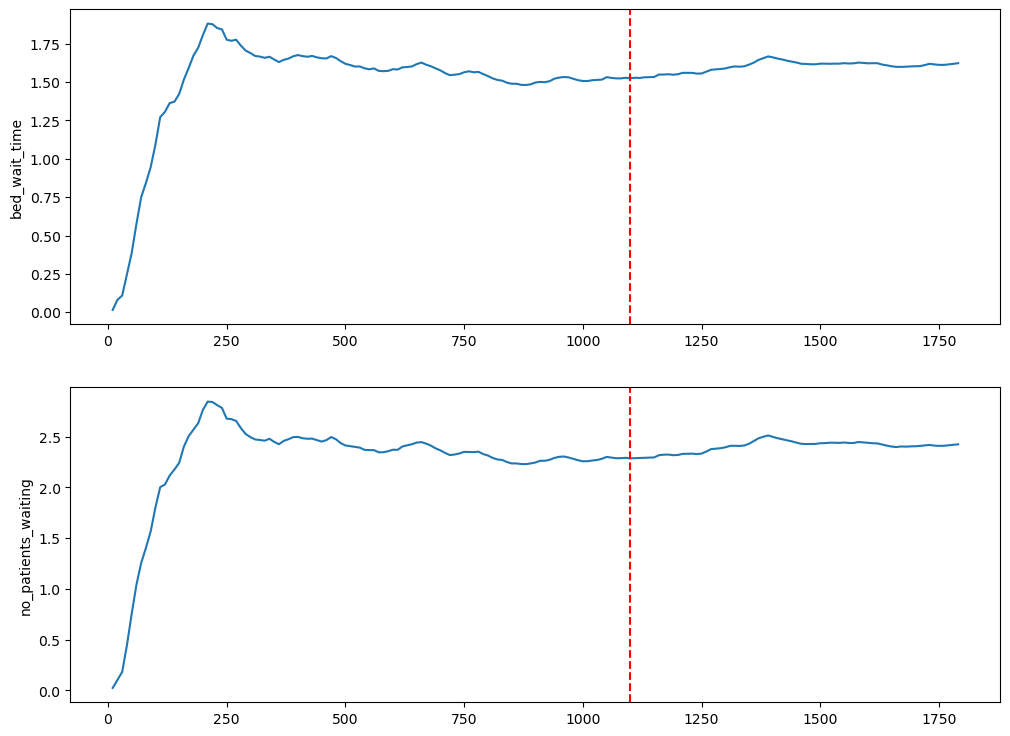

In [19]:
fig, ax = time_series_inspection(results, warm_up=1100)

#### Multiple Replications

In [20]:
# Random results each time the code is run
TRACE = False
results = multiple_runs(gen_rng_set=False, warm_up=1100)
results

Running multiple replications => done.



,mean_bed_wait_time,mean_no_patients_waiting,mean_time_in_system,arrivals,throughput
Rep,,,,,
1,3.344711,5.178854,8.893404,4417,4409
2,1.675197,2.562133,6.979763,4427,4416
3,2.124809,3.291253,7.593726,4436,4428
4,1.483323,2.224735,6.963523,4334,4328
5,1.514848,2.324385,6.880928,4433,4430
6,1.476292,2.169902,7.017511,4391,4369
7,2.663346,4.184629,8.206632,4532,4518
8,1.167724,1.637654,6.562516,4297,4292
9,2.923837,4.537398,8.388745,4412,4403


In [21]:
# Reproducible results
results = multiple_runs(n_reps=15, warm_up=1100)
results

Running multiple replications => done.



,mean_bed_wait_time,mean_no_patients_waiting,mean_time_in_system,arrivals,throughput
Rep,,,,,
1,2.003077,2.999775,7.577499,4445,4440
2,1.553518,2.356081,7.058364,4445,4430
3,2.157547,3.215329,7.543050,4449,4440
4,3.331160,5.176484,8.878034,4465,4456
5,1.800558,2.738341,7.187526,4466,4450
6,1.591287,2.363945,6.960924,4441,4411
7,1.210127,1.737048,6.622878,4345,4333
8,2.404279,3.539672,7.999810,4449,4440
9,0.978222,1.420726,6.416911,4354,4342


Running multiple replications => done.



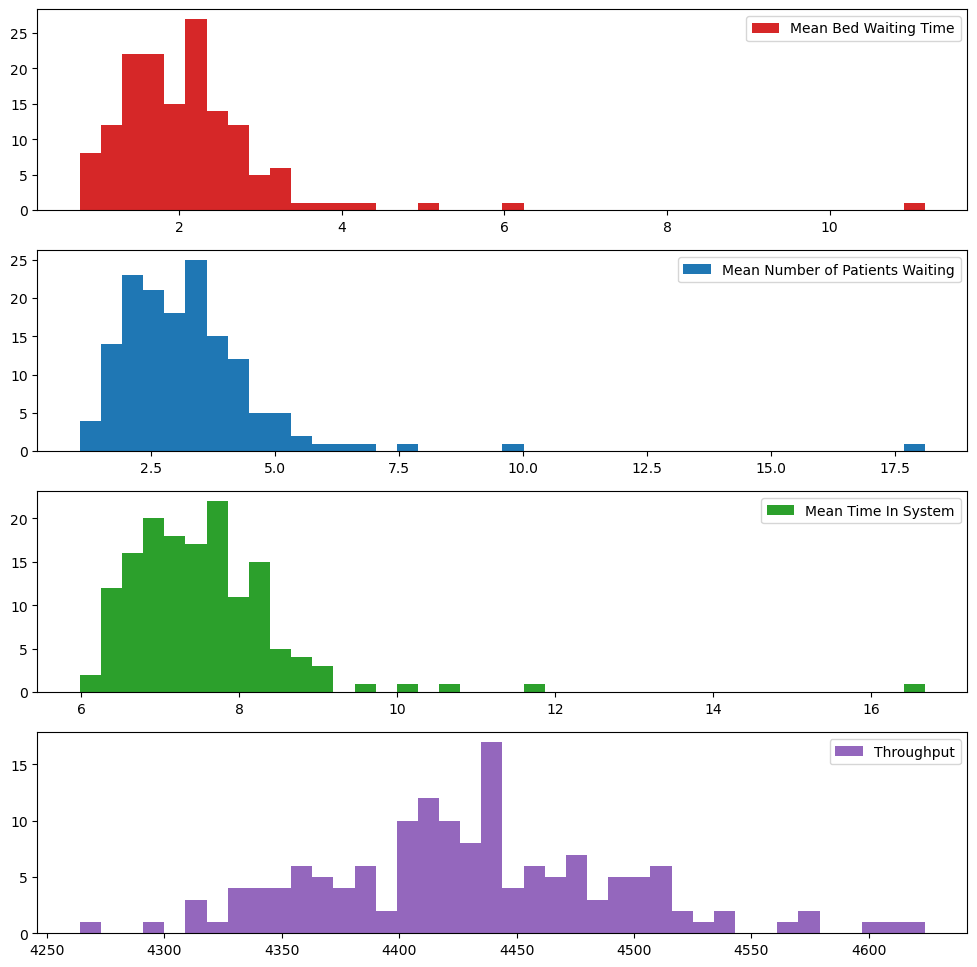

In [22]:
# Histogram of results following multiple replications
results = multiple_runs(n_reps=150, warm_up=1100)
plot_histogram_multiple_run(results)

#### Changing the number of beds

In [23]:
results = multiple_runs(n_reps=15, warm_up=1100, n_beds=14)
results

Running multiple replications => done.



,mean_bed_wait_time,mean_no_patients_waiting,mean_time_in_system,arrivals,throughput
Rep,,,,,
1,0.048623,0.066142,5.620844,4445,4440
2,0.029956,0.041170,5.543343,4445,4440
3,0.046736,0.062935,5.432490,4449,4441
4,0.068789,0.092721,5.609180,4465,4456
5,0.037932,0.050605,5.429438,4466,4459
6,0.065151,0.092037,5.441318,4441,4419
7,0.026765,0.036364,5.438436,4345,4334
8,0.063052,0.091931,5.653836,4449,4440
9,0.029513,0.042719,5.471968,4354,4343


Running multiple replications => done.



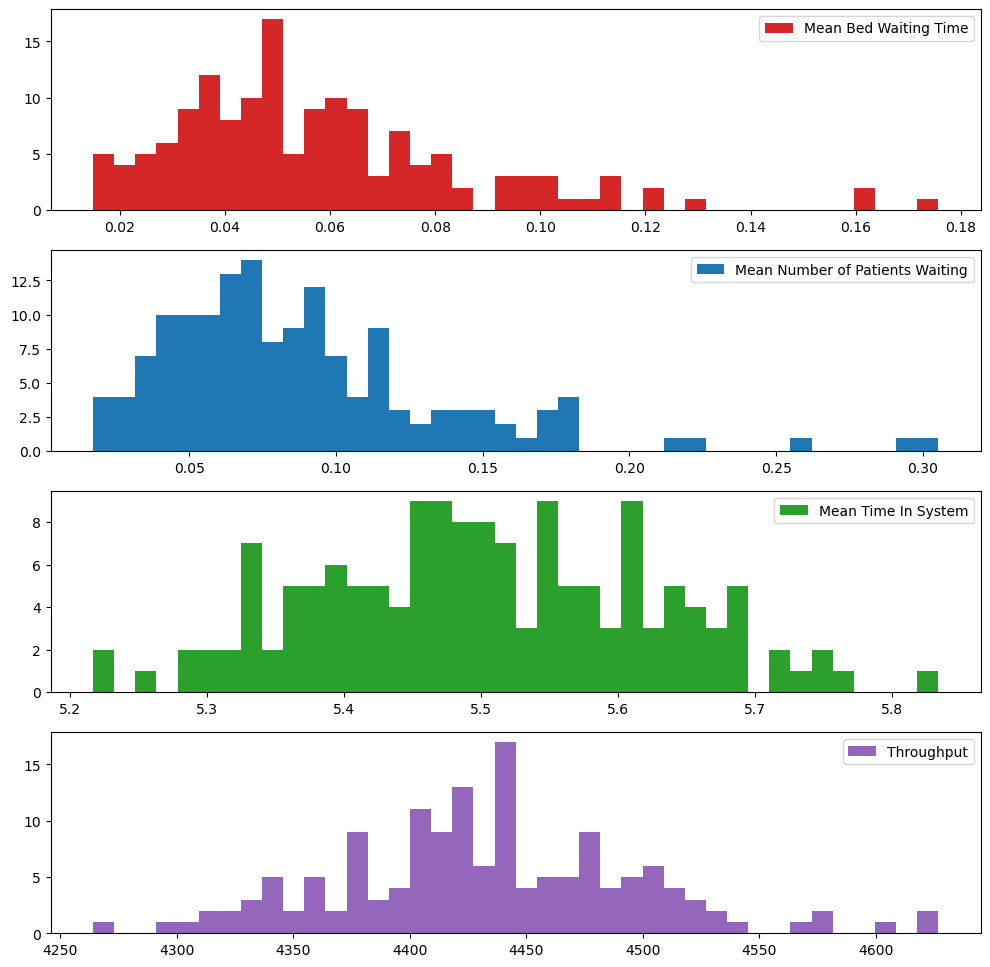

In [24]:
results = multiple_runs(n_reps=150, warm_up=1100, n_beds=14)
plot_histogram_multiple_run(results)